In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import plotly.express as px
import seaborn as sns

# Import Cleaned data

In [90]:
df = pd.read_csv('../Cleaned Data Set/cleaned_data_set_phongho.csv', index_col='timestamp')

In [91]:
df.head()

,Robin_public_Carolina,Robin_lodging_Dorthy,Robin_education_Zenia,Robin_office_Dina,Robin_education_Derick,Robin_education_Della,Robin_education_Leslie,Robin_office_Sammie,Robin_education_Mercedes,Robin_education_Julius,...,Eagle_public_Preston,Eagle_public_Henry,Eagle_education_Norah,Eagle_education_Will,Eagle_education_Petra,Eagle_lodging_Trina,Eagle_health_Amy,Eagle_education_Teresa,Eagle_office_Patrice,Eagle_education_Luther
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,36.438,14.3,52.25,13.3776,229.0,0.3746,324.75,57.75,80.930,117.2,...,247.6250,10.0,426.0,100.875,56.0,17.26,20.0662,98.2779,66.8,433.992
2016-01-01 01:00:00,70.750,27.3,106.25,26.7551,449.5,0.7492,624.75,72.00,166.359,234.4,...,221.8125,28.0,428.0,101.250,57.0,14.59,21.8903,95.3797,64.2,431.994
2016-01-01 02:00:00,74.312,25.7,104.25,26.7551,451.5,0.7492,626.50,66.25,164.868,234.8,...,240.0000,27.0,443.0,101.500,74.0,14.09,19.7090,98.0416,64.6,427.992
2016-01-01 03:00:00,73.438,22.4,107.75,26.7551,445.0,0.7492,630.25,70.00,160.867,236.4,...,222.0625,30.0,436.0,107.125,60.0,16.57,20.1817,91.4560,64.1,431.994
2016-01-01 04:00:00,70.313,20.1,104.50,26.7551,464.0,0.7492,635.00,68.75,158.851,239.8,...,242.1875,31.0,442.0,108.125,60.0,14.94,22.2215,87.8263,66.1,423.996


## Basic Data Description

### Group data by Site and Primary Use

In [92]:
sitbuildloc = df.columns.to_series().str.extract(r'(?P<site>[^_]+)_(?P<usage>[^_]+)_(?P<location>.+)')
sitbuildloc.index = df.columns

sitbuildloc

,site,usage,location
Robin_public_Carolina,Robin,public,Carolina
Robin_lodging_Dorthy,Robin,lodging,Dorthy
Robin_education_Zenia,Robin,education,Zenia
Robin_office_Dina,Robin,office,Dina
Robin_education_Derick,Robin,education,Derick
...,...,...,...
Eagle_lodging_Trina,Eagle,lodging,Trina
Eagle_health_Amy,Eagle,health,Amy
Eagle_education_Teresa,Eagle,education,Teresa
Eagle_office_Patrice,Eagle,office,Patrice


In [93]:
total_kwh = df.sum(axis=0)
sitbuildloc['total_kwh'] = total_kwh

In [94]:
site_usage_counts = sitbuildloc.groupby(['site', 'usage']).size()
site_counts = sitbuildloc.groupby(['site']).size()
usage_counts = sitbuildloc.groupby(['usage']).size()

### Investigate data by site

In [95]:
site_counts_df = site_counts.reset_index()
site_counts_df.columns = ['Site', 'Number of Buildings']
fig = px.bar(site_counts_df, x='Site', y = 'Number of Buildings', title = 'Number of Building per Site')
fig.show()

### Mean Energy Use per Building by Site

In [96]:
building_mean_kwh = sitbuildloc.groupby('site')['total_kwh'].mean().sort_values(ascending=False)
building_mean_kwh_df = building_mean_kwh.reset_index()
building_mean_kwh_df.columns = ['Site', 'Mean Energy Use']
fig = px.bar(building_mean_kwh_df, x='Site', y = 'Mean Energy Use', title = 'Mean Energy Use per Building by Site')
fig.show()

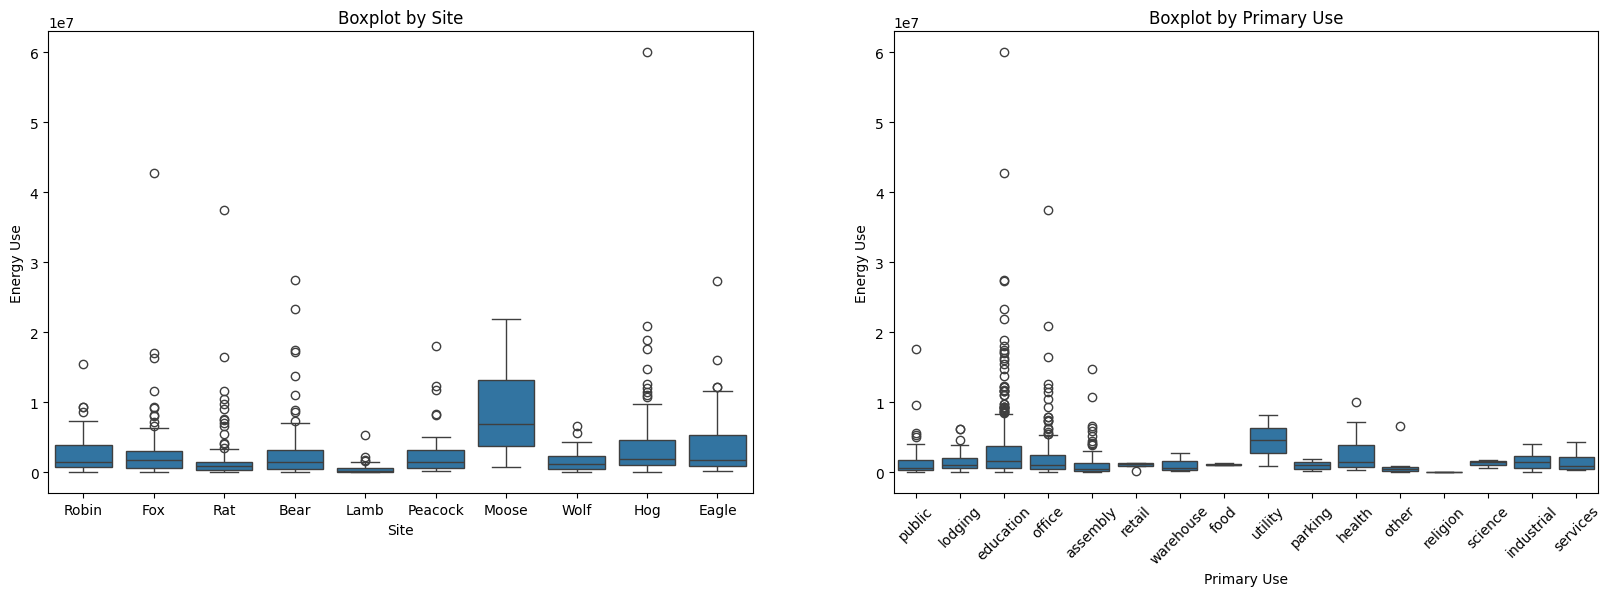

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

sns.boxplot(data=sitbuildloc, x='site', y='total_kwh', ax=axes[0])
axes[0].set_title('Boxplot by Site')
axes[0].set_xlabel('Site')
axes[0].set_ylabel('Energy Use')

sns.boxplot(data=sitbuildloc, x='usage', y='total_kwh', ax=axes[1])
axes[1].set_title('Boxplot by Primary Use')
axes[1].set_xlabel('Primary Use')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylabel('Energy Use')
plt.show()

In [99]:
sitbuildloc[['site', 'total_kwh']]

,site,total_kwh
Robin_public_Carolina,Robin,2.463032e+06
Robin_lodging_Dorthy,Robin,5.449337e+05
Robin_education_Zenia,Robin,3.524524e+06
Robin_office_Dina,Robin,6.245122e+05
Robin_education_Derick,Robin,9.286279e+06
...,...,...
Eagle_lodging_Trina,Eagle,8.263031e+05
Eagle_health_Amy,Eagle,1.411091e+06
Eagle_education_Teresa,Eagle,1.783722e+06
Eagle_office_Patrice,Eagle,1.499432e+06


In [100]:
np.array(all_data).shape

(4, 100)

### Total Energy Use by Site

In [101]:
building_total_kwh = sitbuildloc.groupby('site')['total_kwh'].sum().sort_values(ascending=False)
building_total_kwh_df = building_total_kwh.reset_index()
building_total_kwh_df.columns = ['Site', 'Total Energy Use']
fig = px.bar(building_total_kwh_df, x='Site', y = 'Total Energy Use', title = 'Total Energy by Site')
fig.show()

## Investigate data by Primary Use

In [102]:
usage_counts_df = usage_counts.reset_index()
usage_counts_df.columns = ['Primary Use', 'Number of Buildings']

In [103]:
fig = px.bar(usage_counts_df, x='Primary Use', y = 'Number of Buildings', title = 'Number of Building per Primary Use')
fig.show()

In [104]:
building_mean_kwh = sitbuildloc.groupby('site')['total_kwh'].mean().sort_values(ascending=False)
building_mean_kwh_df = building_mean_kwh.reset_index()
building_mean_kwh_df.columns = ['Site', 'Mean Energy Use']
fig = px.bar(building_mean_kwh_df, x='Site', y = 'Mean Energy Use', title = 'Mean Energy Use per Building by Site')
fig.show()

In [105]:
# Description of all building data
df.describe()

,Robin_public_Carolina,Robin_lodging_Dorthy,Robin_education_Zenia,Robin_office_Dina,Robin_education_Derick,Robin_education_Della,Robin_education_Leslie,Robin_office_Sammie,Robin_education_Mercedes,Robin_education_Julius,...,Eagle_public_Preston,Eagle_public_Henry,Eagle_education_Norah,Eagle_education_Will,Eagle_education_Petra,Eagle_lodging_Trina,Eagle_health_Amy,Eagle_education_Teresa,Eagle_office_Patrice,Eagle_education_Luther
count,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,...,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.00000
mean,140.391702,31.060972,200.896284,35.596908,529.313658,3.182175,885.791079,82.319622,254.837820,345.792968,...,318.570722,29.186047,495.479338,112.525600,66.439210,47.098901,80.431535,101.671324,85.466923,473.45543
std,37.617214,10.317871,52.678726,10.964887,139.723208,3.116188,147.652414,24.032773,62.517733,110.884297,...,78.233983,18.315307,32.077187,11.260463,7.455974,14.230151,34.609369,17.363269,23.906497,32.45101
min,22.641000,0.226200,52.250000,6.500000,3.124100,0.374600,324.750000,23.500000,80.930000,1.944800,...,82.400000,2.000000,330.000000,82.750000,47.000000,7.730000,18.410500,2.721600,53.400000,279.99600
25%,117.562000,22.900000,165.000000,27.500000,476.627125,0.749200,777.558300,63.175000,208.296450,269.400000,...,239.000000,11.000000,473.000000,104.125000,61.000000,38.400000,42.027575,89.731400,66.300000,449.99400
50%,141.102700,31.100000,193.500000,32.823200,529.062750,2.000000,844.023600,80.600000,243.270000,307.400000,...,340.000000,24.000000,494.000000,111.250000,65.000000,45.780000,88.592600,100.647250,77.300000,469.99800
75%,162.749250,37.900000,226.100000,43.000000,613.500000,4.000000,977.916250,97.300000,293.595750,429.600000,...,380.000000,44.000000,516.000000,119.875000,71.000000,56.830000,106.976350,112.349025,100.200000,495.99600
max,268.874000,67.500000,466.200000,83.500000,947.000000,17.000000,1475.000000,162.200000,606.938000,719.400000,...,574.312500,106.000000,628.000000,153.625000,105.000000,90.690000,213.393100,162.620500,172.500000,636.00000
